In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import sys
from scipy.stats import norm
from scipy.optimize import brentq
from scipy import interpolate
from scipy.optimize import least_squares

In [2]:
###Import Data###
discount = pd.read_csv('discount.csv')
call_df = pd.read_csv('goog_call.csv',parse_dates = ['date','expiry'])
call_df['price'] = (call_df['best_bid']+call_df['best_offer'])/2

put_df = pd.read_csv('goog_put.csv',parse_dates = ['date','expiry'])
put_df['price'] = (put_df['best_bid']+put_df['best_offer'])/2


In [3]:
###Call Functions###
def BlackScholesCall(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def impliedCallVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price - BlackScholesCall(S, K, r, x, T), 1e-6, 1)
    return impliedVol

def Bachelier_VanillaCall(S,K,sigma,T):
    d1=(S-K)/(sigma*S*np.sqrt(T))
    return (S-K)*norm.cdf(d1) + sigma*S*np.sqrt(T)*norm.pdf(d1)

def impliedCallVol_Bach(S, K, r, price, T):
    impliedVol_Bach = brentq(lambda x: price - Bachelier_VanillaCall(S,K,x,T), 1e-6, 1)
    return impliedVol_Bach

def DD_VanillaCall(F, K, r, sigma, T, beta):
    Fd=F/beta
    sigmad=sigma*beta
    Kd=K+((1-beta)/beta)*F
    d1 = (np.log(Fd/Kd)+(sigmad**2/2)*T) / (sigmad*np.sqrt(T))
    d2 = d1 - sigmad*np.sqrt(T)
    return np.exp(-r*T)*(Fd*norm.cdf(d1) - Kd*norm.cdf(d2))

In [4]:
###Put Functions###
def BlackScholesPut(S, K, r, sigma, T):
    d1 = (np.log(S/K)+(r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

def impliedPutVolatility(S, K, r, price, T):
    impliedVol = brentq(lambda x: price - BlackScholesPut(S, K, r, x, T), 1e-6, 1)
    return impliedVol

def DD_VanillaPut(F, K, r, sigma, T, beta):
    Fd=F/beta
    sigmad=sigma*beta
    Kd=K+((1-beta)/beta)*F
    d1 = (np.log(Fd/Kd)+(sigmad**2/2)*T) / (sigmad*np.sqrt(T))
    d2 = d1 - sigmad*np.sqrt(T)
    return np.exp(-r*T)*(Kd*norm.cdf(-d2) - Fd*norm.cdf(-d1))

def impliedPutVolatilityDD(S, K, r, price_DD, T, beta):
    impliedVolDD = brentq(lambda x: price_DD - DD_VanillaPut(F, K, r, x, T,B), 1e-6, 1)
    return impliedVolDD

In [5]:
###SABR function###
def SABR(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta)**2)/24)*alpha*alpha/(F**(2 - 2*beta))
        numer2 = 0.25*rho*beta*nu*alpha/(F**(1 - beta))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        VolAtm = alpha*(1 + (numer1 + numer2 + numer3)*T)/(F**(1-beta))
        sabrsigma = VolAtm
    else:
        z = (nu/alpha)*((F*X)**(0.5*(1-beta)))*np.log(F/X)
        zhi = np.log((((1 - 2*rho*z + z*z)**0.5) + z - rho)/(1 - rho))
        numer1 = (((1 - beta)**2)/24)*((alpha*alpha)/((F*X)**(1 - beta)))
        numer2 = 0.25*rho*beta*nu*alpha/((F*X)**((1 - beta)/2))
        numer3 = ((2 - 3*rho*rho)/24)*nu*nu
        numer = alpha*(1 + (numer1 + numer2 + numer3)*T)*z
        denom1 = ((1 - beta)**2/24)*(np.log(F/X))**2
        denom2 = (((1 - beta)**4)/1920)*((np.log(F/X))**4)
        denom = ((F*X)**((1 - beta)/2))*(1 + denom1 + denom2)*zhi
        sabrsigma = numer/denom

    return sabrsigma

def sabrcalibration(x, strikes, vols, F, T):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR(F, strikes[i], T,
                           x[0], 0.8, x[1], x[2]))**2

    return err

In [6]:
###Variables###
S = 846.9 #Google stock price on 30-Aug-2013
Days = 505
y_interp = interpolate.interp1d(discount.iloc[:,0], discount.iloc[:,1]/100)
r = y_interp(Days)
#r = (0.0006*Days+0.0983)/100 #equation from Excel 'discount' interpolation, note: is in %, so /100
T = Days/365 #in years
#strike_call = call_df['strike']
price_call = call_df['price']
price_put = put_df['price']
F = S*np.exp(r*T)
call_df.drop(call_df.index[call_df['strike']<=F],inplace=True)
put_df.drop(put_df.index[put_df['strike']>=F],inplace=True)
###Combine Puts and Calls into df###
df= pd.concat([put_df,call_df], axis=0)
K_closest=min(df['strike'],key=lambda x: abs(x-F))
price_ATM= float(df['price'][df['strike']== K_closest])
sigma_match= brentq(lambda x: price_ATM-DD_VanillaPut(F, K_closest,r, x,T,0.5),1e-6, 1)
sigma = sigma_match
impliedvols = pd.DataFrame()

In [7]:
###Market Data Implied Vol (using ATM implied vols)###
summary_mktcall = []
summary_mktput = []
price_mktlistcall = []
price_mktlistput = []
impliedvol_mktcall = []
impliedvol_mktput = []

for i in call_df.index:
    price = call_df.iloc[i-65][5]
    K = call_df.iloc[i-65][2]
    impliedVol_call = impliedCallVolatility(S, K, r, price, T)
    summary_mktcall.append([K,impliedVol_call])
    impliedvol_mktcall.append(impliedVol_call)
    price_mktlistcall.append(price_call)
    
for i in put_df.index:
    price = put_df.iloc[i][5]
    K = put_df.iloc[i][2]
    impliedVol_put = impliedPutVolatility(S, K, r, price, T)
    summary_mktput.append([K,impliedVol_put])
    impliedvol_mktput.append(impliedVol_put)
    price_mktlistput.append(price_put)
    
call_df['impliedvol'] = impliedvol_mktcall  
put_df['impliedvol'] = impliedvol_mktput
df= pd.concat([put_df,call_df], axis=0)
summary_mkt = summary_mktput + summary_mktcall

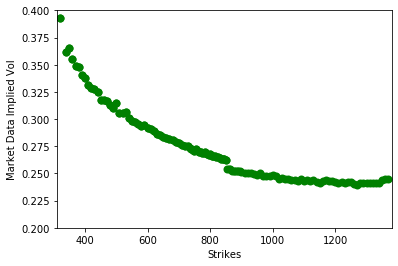

In [8]:
###Plot market Data###
fig = plt.figure()
ax1 = fig.add_subplot(111)

df_mktcall = pd.DataFrame(summary_mkt, columns=['strike', 'vol'])
df_mktput = pd.DataFrame(summary_mktput, columns=['strike', 'vol'])
ax1.scatter(df_mktcall['strike'], df_mktcall['vol'], c='g', linewidth=2.0)
ax1.scatter(df_mktput['strike'], df_mktput['vol'], c='g', linewidth=2.0)
ax1.axis([310, 1380, 0.2, 0.4])
plt.xlabel('Strikes')
plt.ylabel('Market Data Implied Vol')
plt.show()
################

In [9]:
###Displaced-Diffusion Model###

beta_range = np.arange(0.2,1,0.2)
for beta in beta_range:
    summary_DD_call = []
    price_DDcall_list = []
    for i in call_df.index:
        price = DD_VanillaCall(F, call_df.iloc[i-65][2], r, sigma, T, beta)
        K = call_df.iloc[i-65][2]
        impliedVol_DD = impliedCallVolatility(S, K, r, price, T)
        summary_DD_call.append(impliedVol_DD)
        price_DDcall_list.append(price)
    
    summary_DD_put = []
    price_DDput_list = []
    for i in put_df.index:
        price = DD_VanillaPut(F, put_df.iloc[i][2], r, sigma, T, beta)
        K = put_df.iloc[i][2]
        impliedVol_DD = impliedPutVolatility(S, K, r, price, T)
        summary_DD_put.append(impliedVol_DD)
        price_DDput_list.append(price)
        
    summary_DD = summary_DD_put+summary_DD_call
    impliedvols[str(round(beta,1))]=summary_DD

In [10]:
###SABR Model###
initialGuess = [0.02, 0.2, 0.1]
res = least_squares(lambda x: sabrcalibration(x,
                                              df['strike'].values,
                                              df['impliedvol'].values,
                                              F,
                                              T),
                    initialGuess)
alpha = res.x[0]
beta = 0.8
rho = res.x[1]
nu = res.x[2]
sabrsigma_ATM = SABR(F, K_closest, T, alpha, beta, rho, nu)

print('alpha:', alpha)
print('beta:', beta)
print('rho:', rho)
print('nu:', nu)
print('SABR sigma ATM:',sabrsigma_ATM)
print(res)

###SABR Implied Vols###
summarySABR = []
for K in df['strike']:
    impliedvol = SABR(F, K, T, alpha, beta, rho, nu)
    summarySABR.append(impliedvol)

impliedvols['SABR']=summarySABR

alpha: 0.9907772780171966
beta: 0.8
rho: -0.28514715549366737
nu: 0.3522271349016911
SABR sigma ATM: 0.258574177798114
 active_mask: array([0., 0., 0.])
        cost: 1.1875218052106506e-06
         fun: array([0.00154112])
        grad: array([2.02204383e-08, 2.92389158e-08, 2.52296695e-08])
         jac: array([[1.31206325e-05, 1.89725397e-05, 1.63710210e-05]])
     message: 'The maximum number of function evaluations is exceeded.'
        nfev: 300
        njev: 296
  optimality: 2.9238915780519848e-08
      status: 0
     success: False
           x: array([ 0.99077728, -0.28514716,  0.35222713])


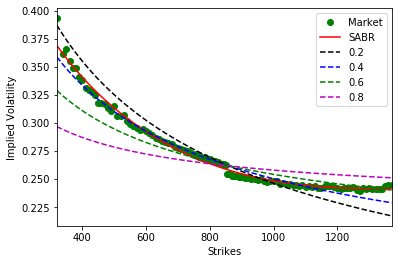

             0.2       0.4       0.6       0.8      SABR    Market
strike                                                            
320.0   0.386934  0.358639  0.328678  0.296550  0.368805  0.393102
340.0   0.378003  0.351558  0.323629  0.293802  0.361070  0.361520
350.0   0.373788  0.348225  0.321260  0.292519  0.357384  0.365782
360.0   0.369727  0.345018  0.318985  0.291291  0.353810  0.355104
370.0   0.365811  0.341929  0.316798  0.290114  0.350344  0.348660
380.0   0.362030  0.338951  0.314695  0.288985  0.346979  0.348356
390.0   0.358377  0.336078  0.312669  0.287900  0.343711  0.340733
400.0   0.354845  0.333304  0.310717  0.286859  0.340537  0.337852
410.0   0.351427  0.330624  0.308834  0.285856  0.337451  0.331197
420.0   0.348118  0.328031  0.307016  0.284891  0.334451  0.328965
430.0   0.344910  0.325523  0.305260  0.283961  0.331532  0.327375
440.0   0.341800  0.323093  0.303562  0.283064  0.328692  0.324626
450.0   0.338782  0.320739  0.301920  0.282198  0.325928  0.31

In [11]:
###Plot Overlays###
impliedvols['SABR']=summarySABR
impliedvols['Market']= df['impliedvol'].values
impliedvols.index = df['strike']
impliedvols[['Market','SABR','0.2','0.4','0.6','0.8']].plot(style=['go','r-','k--','b--','g--','m--'])
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.show()
print(impliedvols)

/Users/seanlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]
/Users/seanlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log
  del sys.path[0]
/Users/seanlow/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in double_scalars
  del sys.path[0]


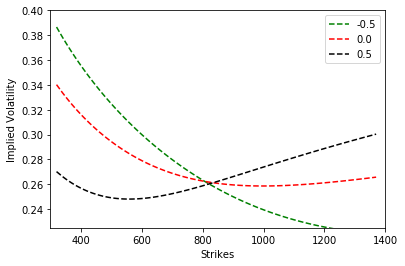

In [12]:
###Vary rho in SABR###
SABR_df_rho = pd.DataFrame()

rho_sabr = np.arange(-0.5,1.5,0.5)
for rho in rho_sabr:
    summary_SABR = []
    for K in df['strike']:
        impliedvol = SABR(F, K, T, 0.9907772780171966, 0.8, rho, 0.3522271349016911)
        summary_SABR.append(impliedvol)
    SABR_df_rho[str(round(rho,1))]=summary_SABR

SABR_df_rho.index = df['strike']

SABR_df_rho[['-0.5','0.0','0.5']].plot(style=['g--','r--','k--'])
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.ylim(.225, 0.400)
plt.xlim(300,1400)
plt.show()

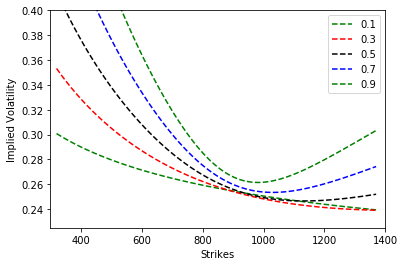

In [13]:
###Vary nu in SABR###
SABR_df_nu = pd.DataFrame()

nu_sabr = np.arange(0.1,1,0.2)
for nu in nu_sabr:
    summary_SABR = []
    for K in df['strike']:
        impliedvol = SABR(F, K, T, 0.9907772780171966, 0.8, -0.28514715549366737, nu)
        summary_SABR.append(impliedvol)
    SABR_df_nu[str(round(nu,1))]=summary_SABR

SABR_df_nu.index = df['strike']

SABR_df_nu[['0.1','0.3','0.5','0.7','0.9']].plot(style=['g--','r--','k--','b--','g--'])
plt.xlabel('Strikes')
plt.ylabel('Implied Volatility')
plt.ylim(.225, 0.400)
plt.xlim(300,1400)
plt.show()